# Importing dependencies

In [1]:
import os
import cv2
import uuid
import glob
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Setting GPU memory limit

In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu[0], True)
    except RuntimeError as e:
        print(e)

# Path and directory set up

In [ ]:
#Set paths
POS_PATH = os.path.join('data','POS_PATH')
NEG_PATH = os.path.join('data', 'NEG_PATH')
ANC_PATH = os.path.join('data', 'ANC_PATH')

#make the directories
if 'data' not in os.listdir():
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)

In [4]:
POS_PATH2 = os.path.join('data2','POS_PATH')
NEG_PATH2 = os.path.join('data2', 'NEG_PATH')
ANC_PATH2 = os.path.join('data2', 'ANC_PATH')

# Collecting and Setting path for NEG Images

In [ ]:
#uncompress tar
if 'lfw' not in os.listdir():
    !tar -xf lfw.tgz

In [ ]:
for file_path in glob.glob('lfw/**/*.jpg'):
    file = file_path.split('\\')[-1]
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(file_path, NEW_PATH)

# Taking pictures with our Webcam

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 220:220+250, :]
    cv2.imshow('Say Cheese!', frame)
    
    #collect anchor
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         #Creating unique file path for ANC 
#         img_name = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
#         #writing image file
#         cv2.imwrite(img_name, frame)
    
    #collect postive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        img_name = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)
        
    #Break out of the webcam
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

# Creating our data Augmentation function

In [5]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.06, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
        
        data.append(img)
        
    return data

In [7]:
for file in os.listdir(ANC_PATH2):
    img_path = os.path.join(ANC_PATH2, file)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH2, f'{uuid.uuid1()}.jpg'), image.numpy())
    

# Preprocessing our Images

## Getting Image Directories

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(3000)

NameError: name 'ANC_PATH' is not defined

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH2 + '\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH2 + '\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH2 + '\*.jpg').take(3000)

## Scaling and Resizing images

In [10]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # load images
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing images to 105 to 105 pixels
    img = tf.image.resize(img, (105, 105))
    
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    return img

In [11]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

### preprocess both our anchor + our postive and negative images

In [12]:
def twin_preprocess(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [13]:
#Build dataloader pipline
data = data.map(twin_preprocess)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Splitting our Data into 70% Training 30% Testing 

In [14]:
# Training partition
train_data = data.take(round(len(data)* .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data)* .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building Embedding Model

In [16]:
def create_embedding_model():
    #Input
    inp = Input(shape=(105,105,3), name = 'input_image')
    
    # first layer
    conv1 = Conv2D(64, (10,10), activation='relu')(inp)
    max1 = MaxPooling2D(64, (2,2), padding='same')(conv1)
    
    # second layer
    conv2 = Conv2D(128, (7,7), activation='relu')(max1)
    max2 = MaxPooling2D(64, (2,2), padding='same')(conv2)
    
    # third layer
    conv3 = Conv2D(128, (4,4), activation='relu')(max2)
    max3 = MaxPooling2D(64, (2,2), padding='same')(conv3)
    
    # final layer
    conv4 = Conv2D(256, (4,4), activation='relu')(max3)
    flat = Flatten()(conv4)
    dense1 = Dense(4096, activation='sigmoid')(flat)
     
    
    return Model(inputs=[inp], outputs=[dense1], name='embedding')

In [17]:
embeded_model = create_embedding_model()

In [18]:
embeded_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

# Building Distance Layer

In [19]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # performing similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
        

# Putting Everything together into a siamese_model

In [20]:
def create_siamese_model():
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embeded_model(input_image), embeded_model(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    

In [21]:
siamese_model = create_siamese_model()

In [22]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Setting up model compilation and checkpoints

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [24]:
opt = tf.keras.optimizers.Adam(1e-4)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Creating our Training functions

In [26]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        
        # Get anchor, positive and negative image
        X = batch[:2]
        
        # Get the label
        y = batch[2]
        
        # Forward pass
        ytrue = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y, ytrue)
    
    print(loss)
    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # update weights adn apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [27]:
def train(data, EPOCHS):
    
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            # Run train step
            loss = train_step(batch)
            ytrue = siamese_model.predict(batch[:2])
            r.update_state(batch[2], ytrue)
            p.update_state(batch[2], ytrue)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Training Our Model

In [28]:
EPOCHS = 10

In [29]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 106s 381ms/step
0.045114055 0.9056604 0.9751143

 Epoch 2/10
263/263 [==============================] - 99s 377ms/step
0.008873186 0.9686461 0.9922141

 Epoch 3/10
263/263 [==============================] - 97s 370ms/step
0.0126946755 0.9800095 0.99038

 Epoch 4/10
263/263 [==============================] - 95s 362ms/step
0.053175256 0.98498356 0.9905616

 Epoch 5/10
263/263 [==============================] - 92s 349ms/step
0.0013932327 0.98571426 0.995671

 Epoch 6/10
263/263 [==============================] - 90s 341ms/step
0.036506575 0.9886364 0.99286735

 Epoch 7/10
263/263 [==============================] - 89s 340ms/step
0.061752357 0.9841651 0.9922593

 Epoch 8/10
263/263 [==============================] - 93s 352ms/step
0.028346835 0.993762 0.99471664

 Epoch 9/10
263/26

# Testing our Model

In [75]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [76]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [1.2937964e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.2318045e-03],
       [1.0000000e+00],
       [1.1639569e-02],
       [1.0000000e+00],
       [6.6149269e-06],
       [4.7473801e-05],
       [9.9980956e-01],
       [7.8214593e-03],
       [4.0602004e-06],
       [1.0000000e+00],
       [1.6676657e-03],
       [1.0000000e+00]], dtype=float32)

In [77]:
[1 if prediction > 0.5 else 0 for prediction in y_true]

[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

In [78]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [79]:
pred = Recall()

pred.update_state(y_true, y_hat)

pred.result().numpy()

1.0

In [80]:
pred = Precision()

pred.update_state(y_true, y_hat)

pred.result().numpy()

1.0

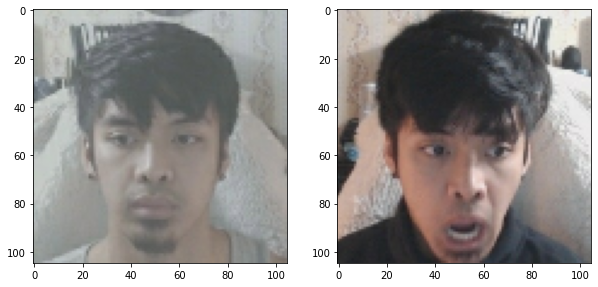

In [83]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

# Saving our model

In [65]:
siamese_model.save('siamesemodelv3.h5')

# Loading our model

In [66]:
model = tf.keras.models.load_model('siamesemodelv3.h5', custom_objects={'L1Dist':L1Dist})

In [67]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real Time Test

In [68]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified
    

In [74]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 220:220+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application->input_image dir
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        results, verified = verify(model, 0.5, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
    

False
False
False
False
False
